In [34]:
import sys
import time
import dotenv
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import StratifiedKFold

In [35]:
sys.path.append("../..")
from src.algorithms.AntMiner import AntMiner

In [36]:
env = dotenv.find_dotenv()
df = pd.read_csv(dotenv.get_key(env, 'DATA_DIR'))

X = df.drop('class', axis=1)
y = df['class'].astype(str)

In [37]:
args = {
    'max_ants': 3000,
    'max_uncovered': 10,
    'min_covers': 10,
    'nb_converge': 10,
    'alpha': 1,
    'beta': 1,
    'pruning': 0,
}

In [38]:
sets = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

In [39]:
def cross_validation(X, y, sets, args):

    results = pd.DataFrame(columns=['fold', 'time', 'accuracy', 'f1_score', 'rules'])
    archive = []
    fitness_archive = []

    print(f"Running cross-validation with {sets.n_splits} folds...")
    for i, (train_index, test_index) in enumerate(sets.split(X, y)):

        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
        ant_miner = AntMiner(
            max_ants=args['max_ants'],
            max_uncovered=args['max_uncovered'],
            min_covers=args['min_covers'],
            nb_converge=args['nb_converge'],
            alpha=args['alpha'],
            beta=args['beta'],
            pruning=args['pruning']
        )

        start_time = time.time()
        ant_miner.fit(X_train, y_train)
        end_time = time.time()

        elapsed_time = end_time - start_time
    
        # Evaluate the model on the test set
        accuracy, f1_score = ant_miner.evaluate(X_test, y_test)

        results.loc[i] = [i + 1, elapsed_time, accuracy*100, f1_score*100, len(ant_miner.discovered_rules)]

        archive.append(ant_miner.discovered_rules)
        fitness_archive.append(ant_miner.fitness_archive)
        print(f"Fold {i + 1}: Time: {elapsed_time:.2f}s, Accuracy: {accuracy*100:.2f}%, F1 Score: {f1_score*100:.2f}%, Rules: {len(ant_miner.discovered_rules)}")

    print("Cross-validation completed.")
    return results, archive, fitness_archive

In [40]:
results, archive, fitness = cross_validation(X, y, sets, args)

Running cross-validation with 10 folds...
Fold 1: Time: 60.57s, Accuracy: 69.79%, F1 Score: 70.08%, Rules: 21
Fold 2: Time: 39.25s, Accuracy: 77.08%, F1 Score: 76.70%, Rules: 17
Fold 3: Time: 45.18s, Accuracy: 65.62%, F1 Score: 52.00%, Rules: 17
Fold 4: Time: 55.65s, Accuracy: 70.83%, F1 Score: 71.03%, Rules: 18
Fold 5: Time: 59.71s, Accuracy: 64.58%, F1 Score: 65.01%, Rules: 21
Fold 6: Time: 66.56s, Accuracy: 67.71%, F1 Score: 67.59%, Rules: 18
Fold 7: Time: 59.66s, Accuracy: 60.42%, F1 Score: 54.92%, Rules: 21
Fold 8: Time: 57.39s, Accuracy: 61.46%, F1 Score: 61.32%, Rules: 22
Fold 9: Time: 63.98s, Accuracy: 70.53%, F1 Score: 66.17%, Rules: 20
Fold 10: Time: 54.58s, Accuracy: 63.16%, F1 Score: 60.39%, Rules: 21
Cross-validation completed.


In [14]:
results

,fold,time,accuracy,f1_score,rules
0,1.0,45.890394,69.791667,70.351531,18.0
1,2.0,56.778131,65.625000,52.004717,20.0
2,3.0,55.361115,65.625000,52.004717,20.0
3,4.0,54.465596,70.833333,71.027040,18.0
4,5.0,59.747969,67.708333,67.001158,23.0
5,6.0,52.826194,67.708333,67.587068,16.0
6,7.0,51.185736,64.583333,50.685654,19.0
7,8.0,57.641791,75.000000,73.027375,16.0
8,9.0,54.484017,73.684211,72.124756,19.0
9,10.0,42.097443,63.157895,63.283071,20.0


In [15]:
print(f"Average Accuracy: {results['accuracy'].mean():.2f}% ± {results['accuracy'].std():.2f}%")
print(f"Average F1 Score: {results['f1_score'].mean():.2f}% ± {results['f1_score'].std():.2f}%")
print(f"Average Rules: {results['rules'].mean():.2f} ± {results['rules'].std():.2f}")
print(f"Average Time: {results['time'].mean():.2f}s ")

Average Accuracy: 68.37% ± 3.91%
Average F1 Score: 63.91% ± 8.97%
Average Rules: 18.90 ± 2.08
Average Time: 53.05s 


In [16]:
def plot_pareto_per_run(all_fitness_archives):
    """
    Plot fitness points for each run with 10 folds (2 rows × 5 cols).
    Assumes fitness values are directly stored in a list of tuples (sensitivity, specificity).
    """

    sns.set(style="whitegrid")

    for run_idx, run_fitness in enumerate(all_fitness_archives):
        fig, axes = plt.subplots(2, 5, figsize=(18, 7))
        fig.suptitle(f"Ant-Miner: Pareto Fronts Across 10 for TicTacToe Dataset", fontsize=18)

        for fold_idx, fitness_list in enumerate(run_fitness):
            ax = axes[fold_idx // 5, fold_idx % 5]

            if fitness_list:
                fitness_array = np.array(fitness_list)
                ax.scatter(
                    fitness_array[:, 0],
                    fitness_array[:, 1],
                    s=25,
                    color='dodgerblue',
                    alpha=0.7,
                    edgecolors='black',
                    linewidth=0.3
                )

            ax.set_title(f"Fold {fold_idx + 1}", fontsize=12)
            ax.set_xlabel("Sensitivity")
            ax.set_ylabel("Specificity")
            ax.grid(True, linestyle='--', alpha=0.6)

        plt.tight_layout(rect=[0, 0, 1, 0.95])
        plt.show()

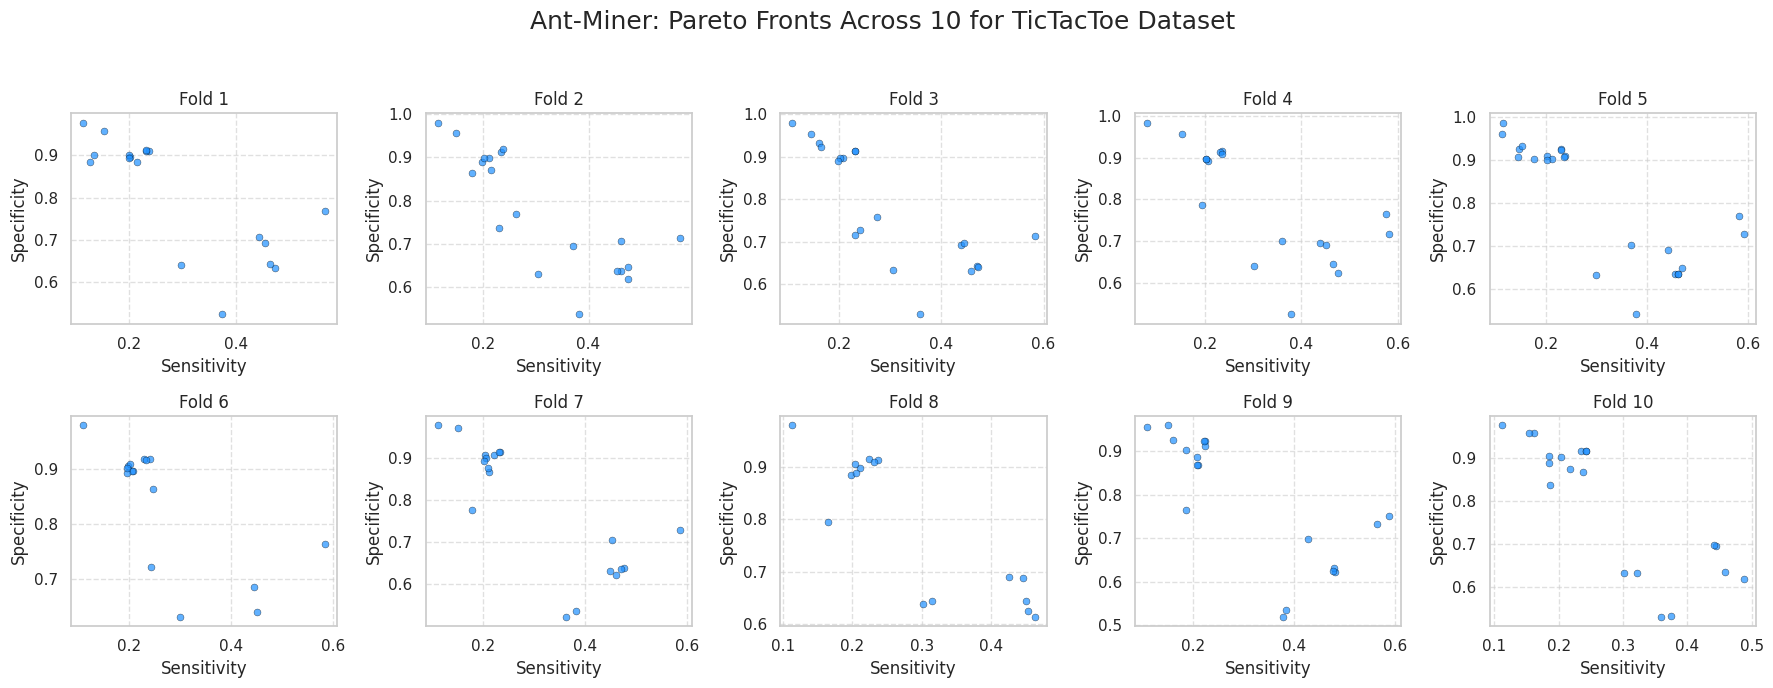

In [17]:
plot_pareto_per_run([fitness]) 

In [32]:
def plot_all_fitness_points(all_fitness_archives, folds=10):
    """
    Plot all fitness points (sensitivity, specificity) from all runs and folds
    in a single scatter plot.
    - Single color
    - No legend
    - No lines
    """

    sns.set(style="whitegrid")
    colors = sns.color_palette("husl", n_colors=folds)
    plt.figure(figsize=(10, 8))

    for run_fitness in all_fitness_archives:
        for i,fitness_list in enumerate(run_fitness):
            if fitness_list:
                fitness_array = np.array(fitness_list)
                plt.scatter(
                    fitness_array[:, 0],
                    fitness_array[:, 1],
                    label=f'Fold {i+1}',
                    s=60,
                    color=colors[i],
                    edgecolor='black',
                    alpha=0.8
                )

    plt.title("Ant-Miner: Pareto Fronts Across 10 for TicTacToe Dataset", fontsize=16)
    plt.xlabel("Sensitivity", fontsize=14)
    plt.ylabel("Specificity", fontsize=14)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend(title="Folds")
    plt.tight_layout()
    plt.show()

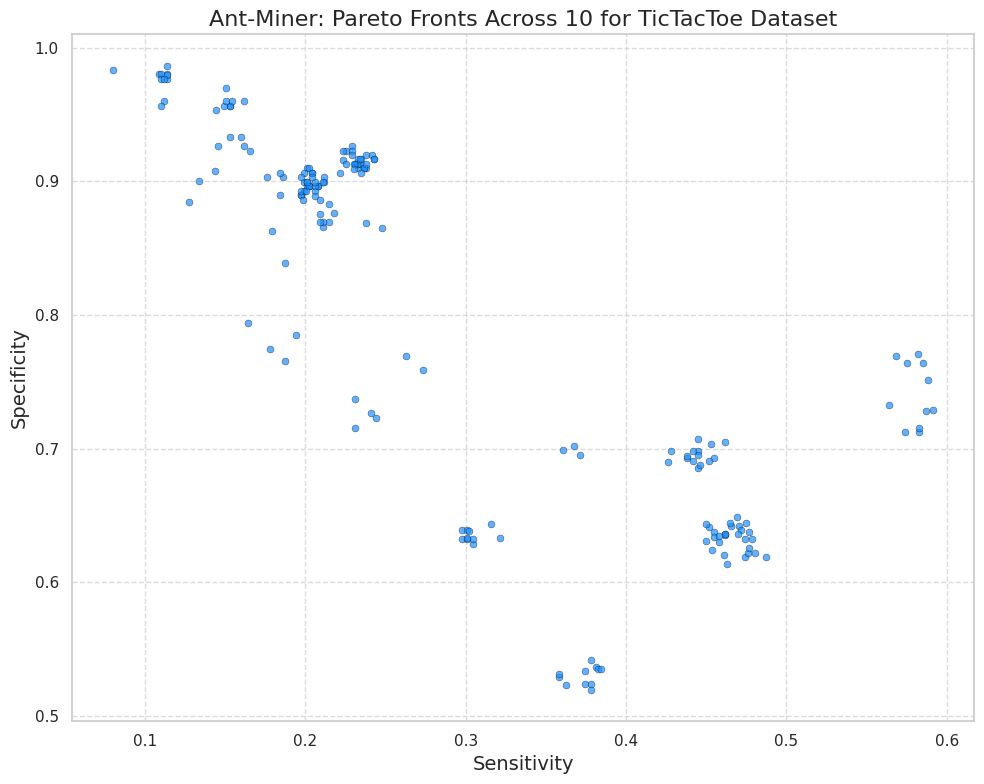

In [19]:
plot_all_fitness_points([fitness])

### Loading Ljubljana Dataset

In [20]:
df = pd.read_csv('/home/adel/Documents/Code/Ant-Miner/datasets/ljubljana.csv')

X = df.drop('class', axis=1)
y = df['class'].astype(str)
df['deg-malig'] = df['deg-malig'].astype(str)
df['irradiat'] = df['irradiat'].astype(str)

In [21]:
# handling missing values with mode
X['falsede-caps'] = X['falsede-caps'].fillna(X['falsede-caps'].mode()[0])
X['breast-quad'] = X['breast-quad'].fillna(X['breast-quad'].mode()[0])

/tmp/ipykernel_7267/1797399104.py:2: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X['falsede-caps'] = X['falsede-caps'].fillna(X['falsede-caps'].mode()[0])


In [22]:
results, archive, fitness = cross_validation(X, y, sets, args)

Running cross-validation with 10 folds...
Fold 1: Time: 6.56s, Accuracy: 71.43%, F1 Score: 62.48%, Rules: 7
Fold 2: Time: 3.85s, Accuracy: 78.57%, F1 Score: 77.55%, Rules: 6
Fold 3: Time: 8.16s, Accuracy: 70.37%, F1 Score: 66.84%, Rules: 7
Fold 4: Time: 8.87s, Accuracy: 55.56%, F1 Score: 57.45%, Rules: 7
Fold 5: Time: 9.13s, Accuracy: 70.37%, F1 Score: 66.84%, Rules: 7
Fold 6: Time: 6.30s, Accuracy: 81.48%, F1 Score: 80.02%, Rules: 7
Fold 7: Time: 16.99s, Accuracy: 70.37%, F1 Score: 58.13%, Rules: 7
Fold 8: Time: 11.01s, Accuracy: 70.37%, F1 Score: 63.50%, Rules: 9
Fold 9: Time: 13.69s, Accuracy: 74.07%, F1 Score: 72.03%, Rules: 6
Fold 10: Time: 45.24s, Accuracy: 70.37%, F1 Score: 58.13%, Rules: 6
Cross-validation completed.


In [23]:
results

,fold,time,accuracy,f1_score,rules
0,1.0,6.558738,71.428571,62.484472,7.0
1,2.0,3.851236,78.571429,77.551020,6.0
2,3.0,8.159049,70.370370,66.843034,7.0
3,4.0,8.866363,55.555556,57.449495,7.0
4,5.0,9.127684,70.370370,66.843034,7.0
5,6.0,6.304012,81.481481,80.022236,7.0
6,7.0,16.989551,70.370370,58.132045,7.0
7,8.0,11.010833,70.370370,63.501684,9.0
8,9.0,13.686073,74.074074,72.031131,6.0
9,10.0,45.244386,70.370370,58.132045,6.0


In [24]:
print(f"Average Accuracy: {results['accuracy'].mean():.2f}% ± {results['accuracy'].std():.2f}%")
print(f"Average F1 Score: {results['f1_score'].mean():.2f}% ± {results['f1_score'].std():.2f}%")
print(f"Average Rules: {results['rules'].mean():.2f} ± {results['rules'].std():.2f}")
print(f"Average Time: {results['time'].mean():.2f}s ")

Average Accuracy: 71.30% ± 6.80%
Average F1 Score: 66.30% ± 8.04%
Average Rules: 6.90 ± 0.88
Average Time: 12.98s 


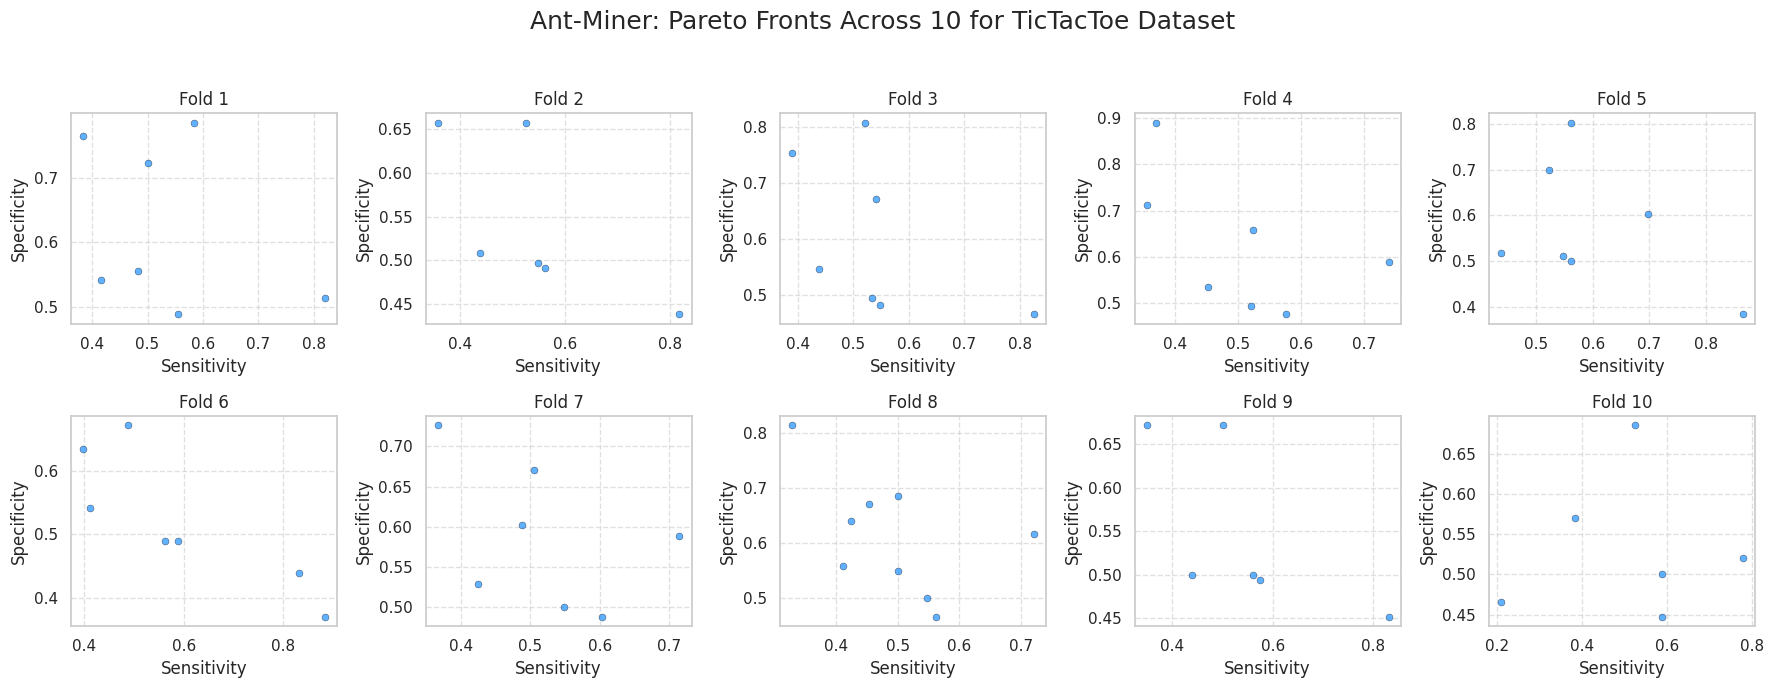

In [26]:
plot_pareto_per_run([fitness])

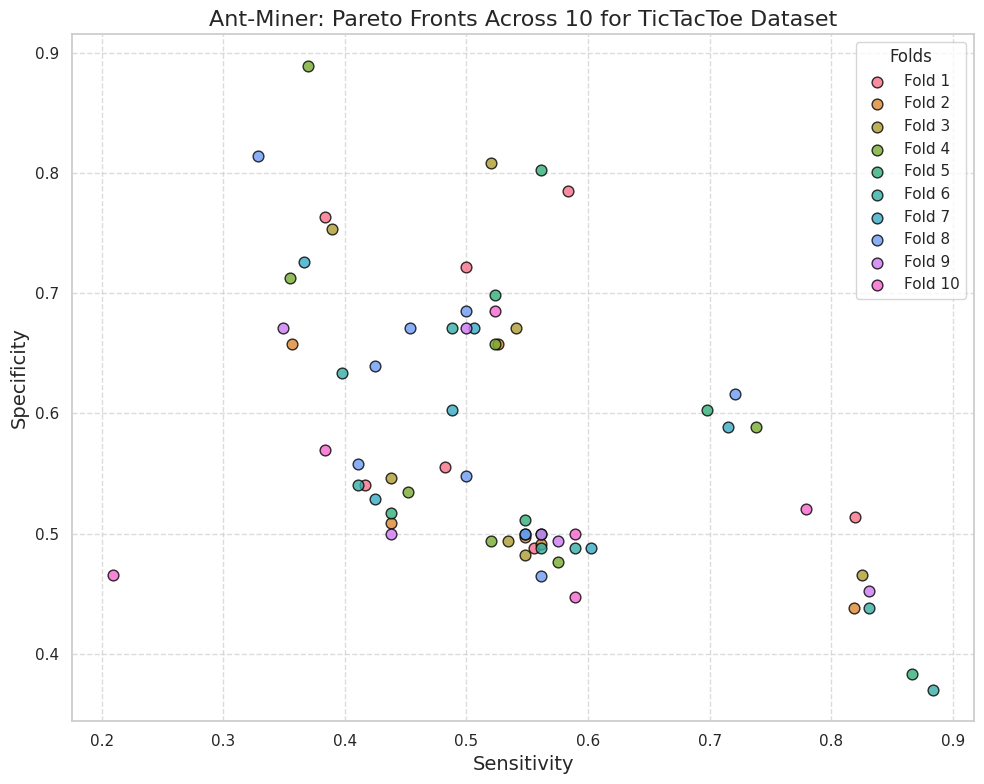

In [33]:
plot_all_fitness_points([fitness])